# Week 10

In this week we explore all the capabilities and features when dealing 
with a `.json` file.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from py4j.protocol import Py4JJavaError     # An error object for catching Py4JJJavaError
from IPython.display import Image, HTML, display

import json
import pprint
import re


In [2]:
spark = (SparkSession
  .builder
  .master("local[*]") 
  .appName("Processing JSON")
  .getOrCreate())


Read `.json` file with json built-in library in Python

In [7]:
with open("./data/shows/shows-silicon-valley.json", 'r') as f_json:
  data = f_json.read()
shows_json = json.loads(data)

# display(shows_json)
pprint.pp(shows_json)


{'id': 143,
 'url': 'https://www.tvmaze.com/shows/143/silicon-valley',
 'name': 'Silicon Valley',
 'type': 'Scripted',
 'language': 'English',
 'genres': ['Comedy'],
 'status': 'Ended',
 'runtime': 30,
 'averageRuntime': 30,
 'premiered': '2014-04-06',
 'ended': '2019-12-08',
 'officialSite': 'http://www.hbo.com/silicon-valley/',
 'schedule': {'time': '22:00', 'days': ['Sunday']},
 'rating': {'average': 8.4},
 'weight': 89,
 'network': {'id': 8,
             'name': 'HBO',
             'country': {'name': 'United States',
                         'code': 'US',
                         'timezone': 'America/New_York'},
             'officialSite': 'https://www.hbo.com/'},
 'webChannel': None,
 'dvdCountry': None,
 'externals': {'tvrage': 33759, 'thetvdb': 277165, 'imdb': 'tt2575988'},
 'image': {'medium': 'https://static.tvmaze.com/uploads/images/medium_portrait/215/538434.jpg',
           'original': 'https://static.tvmaze.com/uploads/images/original_untouched/215/538434.jpg'},
 'summar

Read `.json` file with PySpark

In [8]:
shows = spark.read.json("./data/shows/shows-silicon-valley.json")
shows.count()

1

The above `.json` file contains a single line. If we read prettify (human readable)
version, we will get count() is the number of lines

In [6]:
spark.read.json("./data/shows/prettify-shows-silicon-valley.json").count()

1599

Let us see the structure of the columns in `shows-silicon-valley.json`

In [7]:
shows.printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |    |-- show: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- rating:

As we can see, there are some columns inside columns (or struct inside struct
or dataframe inside a dataframe, or table inside table).    
We also notice there is an array inside a column (`episodes` column).   

In the below figure, you can see how they are related to each other

<img src="./img-resources/06-multidim-data-shows-json-structure.png" width=1000>

## Array within struct

If we look at `genres` keys, its element is an array.

In [11]:
array_subset = shows.select("name", "genres")
array_subset.show(1, False)

+--------------+--------+
|name          |genres  |
+--------------+--------+
|Silicon Valley|[Comedy]|
+--------------+--------+



How to get the element of an array. There are many ways to do that:
- by dot and index: `dataframe.key[idx]`
- by column function and index: `F.col("key")[idx]`
- by dot and column method : `dataframe.key.getItem(idx)`
- by column function and column method: `F.col("key").getItem(idx)`

In [12]:
array_subset_indexing = array_subset.select(
  "name", 
  array_subset.genres[0].alias("dot_and_index"),
  F.col("genres")[0].alias("col_and_index"),
  array_subset.genres.getItem(0).alias("dot_and_method"),
  F.col("genres").getItem(0).alias("col_and_method")
)

array_subset_indexing.show()


+--------------+-------------+-------------+--------------+--------------+
|          name|dot_and_index|col_and_index|dot_and_method|col_and_method|
+--------------+-------------+-------------+--------------+--------------+
|Silicon Valley|       Comedy|       Comedy|        Comedy|        Comedy|
+--------------+-------------+-------------+--------------+--------------+



For our learning purpose, let us add some other genres. We can use 
`F.lit()` to create a new column with a value

In [13]:
array_more_genres = array_subset.select(
  "name",
  F.lit("Science").alias("one"),
  F.lit("Romance").alias("two"),
  F.lit("Drama").alias("three"),
  F.col("genres")
)

array_more_genres.show(1, False)

+--------------+-------+-------+-----+--------+
|name          |one    |two    |three|genres  |
+--------------+-------+-------+-----+--------+
|Silicon Valley|Science|Romance|Drama|[Comedy]|
+--------------+-------+-------+-----+--------+



Now we can create two new columns:
-  `some_genres` that is collection from columns `one`, `two`, `three`, and `genres`
-  `repeated_genres` that is a column with a repeated element

In [21]:
array_demo_operations = array_more_genres.select(
  "name",
  F.array("one", "two", "three", F.col("genres")[0]).alias("some_genres"),
  F.array_repeat(F.col("genres")[0], 5).alias("repeated_genres")
)

array_demo_operations.show(1, False)

+--------------+---------------------------------+----------------------------------------+
|name          |some_genres                      |repeated_genres                         |
+--------------+---------------------------------+----------------------------------------+
|Silicon Valley|[Science, Romance, Drama, Comedy]|[Comedy, Comedy, Comedy, Comedy, Comedy]|
+--------------+---------------------------------+----------------------------------------+



In Array type, there are many useful functions. Here we only shows
some array functions. For complete list, see the documentation under the 
category ["Collection functions"](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html#collection-functions)

In [25]:
# Get the size of an array
array_demo_operations.select(
  "name", F.size("some_genres"), F.size("repeated_genres")
).show(1, False)

# Get distinct element
array_demo_operations.select(
  "name", F.array_distinct("some_genres"), F.array_distinct("repeated_genres")
).show(1, False)

# Get the elements of the intersection of two arrays
array_demo_operations.select(
  "name", F.array_intersect("some_genres", "repeated_genres")
).show(1, False)

# Get the specific position of an element in an array.
# This array position will give an output with onev based index.
array_demo_operations.select(
  "some_genres", F.array_position("some_genres", "Drama")
).show(1, False)

+--------------+-----------------+---------------------+
|name          |size(some_genres)|size(repeated_genres)|
+--------------+-----------------+---------------------+
|Silicon Valley|4                |5                    |
+--------------+-----------------+---------------------+

+--------------+---------------------------------+-------------------------------+
|name          |array_distinct(some_genres)      |array_distinct(repeated_genres)|
+--------------+---------------------------------+-------------------------------+
|Silicon Valley|[Science, Romance, Drama, Comedy]|[Comedy]                       |
+--------------+---------------------------------+-------------------------------+

+--------------+---------------------------------------------+
|name          |array_intersect(some_genres, repeated_genres)|
+--------------+---------------------------------------------+
|Silicon Valley|[Comedy]                                     |
+--------------+------------------------------

## Map within column

A concept of data type mnap is a generalization of an array where the index 
can be any types.  
The type of the key must be same.     
In array data type, we only have integers as the indices and any data type in 
its element, but in map, we have two pairs of values which are called "key" and "values".  
This "key" is our generalized index. And the "value" is the value of our generalized array

In PySpark, it is denoted by the notation   
```md
{key1 -> val1, key2 -> val2, key3 -> val3, ...}
```

First we need to demonstrate how to construct a column with a map as its element.

In [31]:
# Create a four-column table where the last column is an array type
columns = ["name", "language", "type"]

shows_map_1 = shows.select(
  *[F.lit(column) for column in columns],
  F.array(*columns).alias("values"))

print(f"Table 1")
shows_map_1.show(1, False)

Table 1
+----+--------+----+-----------------------------------+
|name|language|type|values                             |
+----+--------+----+-----------------------------------+
|name|language|type|[Silicon Valley, English, Scripted]|
+----+--------+----+-----------------------------------+



In [32]:
# Turn `shows_map` into two-column table where each column is an array type
shows_map_2 = shows_map_1.select(F.array(*columns).alias("keys"), "values")

print(f"Table 2")
shows_map_2.show(1, False)

Table 2
+----------------------+-----------------------------------+
|keys                  |values                             |
+----------------------+-----------------------------------+
|[name, language, type]|[Silicon Valley, English, Scripted]|
+----------------------+-----------------------------------+



In [38]:
# Turn `shows_map` into a single column table where the column is a map type
shows_map = shows_map_2.select(
  F.map_from_arrays("keys", "values").alias("mapped"))
print(f"Table 3")
shows_map.show(1, False)

# Show the schema for this table that contains a map type column
shows_map.printSchema()

Table 3
+---------------------------------------------------------------+
|mapped                                                         |
+---------------------------------------------------------------+
|{name -> Silicon Valley, language -> English, type -> Scripted}|
+---------------------------------------------------------------+

root
 |-- mapped: map (nullable = false)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



Three different ways to access may type column

In [39]:
print(f"Table 4: Accessing value of a mapped")
shows_map.select(
  F.col("mapped.name").alias("F.col(mapped.name)"),
  F.col("mapped")["name"].alias('F.col("mapped")["name"])'),
  shows_map.mapped["name"].alias('shows_map.mapped["name"]')
).show(1, False)


Table 4: Accessing value of a mapped
+------------------+------------------------+------------------------+
|F.col(mapped.name)|F.col("mapped")["name"])|shows_map.mapped["name"]|
+------------------+------------------------+------------------------+
|Silicon Valley    |Silicon Valley          |Silicon Valley          |
+------------------+------------------------+------------------------+



## Struct within struct

A struct is a generalization of a map where
we can have different data types in the keys, 
and also different data types in the values

A struct type is denoted by the following notation with a curly braces
```md
{elem1, elem2, elem3, ...}
```

Now we take a look to the schema of `shows`.  
We can see that inside the element of `episodes`, there is a struct `_links`
where it is also a struct. 

<img src="./img-resources/06-multidim-data-shows-_links.png" width=800>

In [45]:
shows.printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |    |-- show: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- rating:

We can access those struct within struct with the following command

In [48]:
shows.select(F.col("_embedded.episodes")[0]).show(1, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [50]:
(shows
  .select(F.col("_embedded.episodes")[0].alias("episode00"))
  .select(F.col("episode00._links"))
  .show(1, False))

+---------------------------------------------------------------------------------------------+
|_links                                                                                       |
+---------------------------------------------------------------------------------------------+
|{{https://api.tvmaze.com/episodes/10897}, {https://api.tvmaze.com/shows/143, Silicon Valley}}|
+---------------------------------------------------------------------------------------------+



## Explore `_embedded` struct

<img src="./img-resources/06-multidim-data-shows-_embedded.png" width=1000>

How many numbers of episodes in `shows`?

In [52]:
(shows.select("_embedded.episodes")
  .select(F.size(F.col("episodes")))
  .show(1, False))

+--------------+
|size(episodes)|
+--------------+
|53            |
+--------------+



Walking down to the table of `_embedded.episodes[0]._links.self.href` and 
`_embedded.episodes[0]._links.show`

In [56]:
(shows.select("_embedded.episodes")
  .select(F.col("episodes")[0].alias("element00"))
  .select(F.col("element00._links.self.href"))
  .show(1, False))

(shows.select("_embedded.episodes")
  .select(F.col("episodes")[0].alias("element00"))
  .select(F.col("element00._links.show"))
  .show(1, False))

+-------------------------------------+
|href                                 |
+-------------------------------------+
|https://api.tvmaze.com/episodes/10897|
+-------------------------------------+

+--------------------------------------------------+
|show                                              |
+--------------------------------------------------+
|{https://api.tvmaze.com/shows/143, Silicon Valley}|
+--------------------------------------------------+



Get the table of `image: struct` in `_embedded.episodes[0].image`

+-----------------------------------------------------------------------+
|medium                                                                 |
+-----------------------------------------------------------------------+
|https://static.tvmaze.com/uploads/images/medium_landscape/49/123633.jpg|
+-----------------------------------------------------------------------+



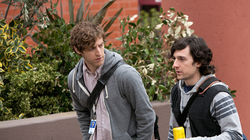

+-------------------------------------------------------------------------+
|original                                                                 |
+-------------------------------------------------------------------------+
|https://static.tvmaze.com/uploads/images/original_untouched/49/123633.jpg|
+-------------------------------------------------------------------------+



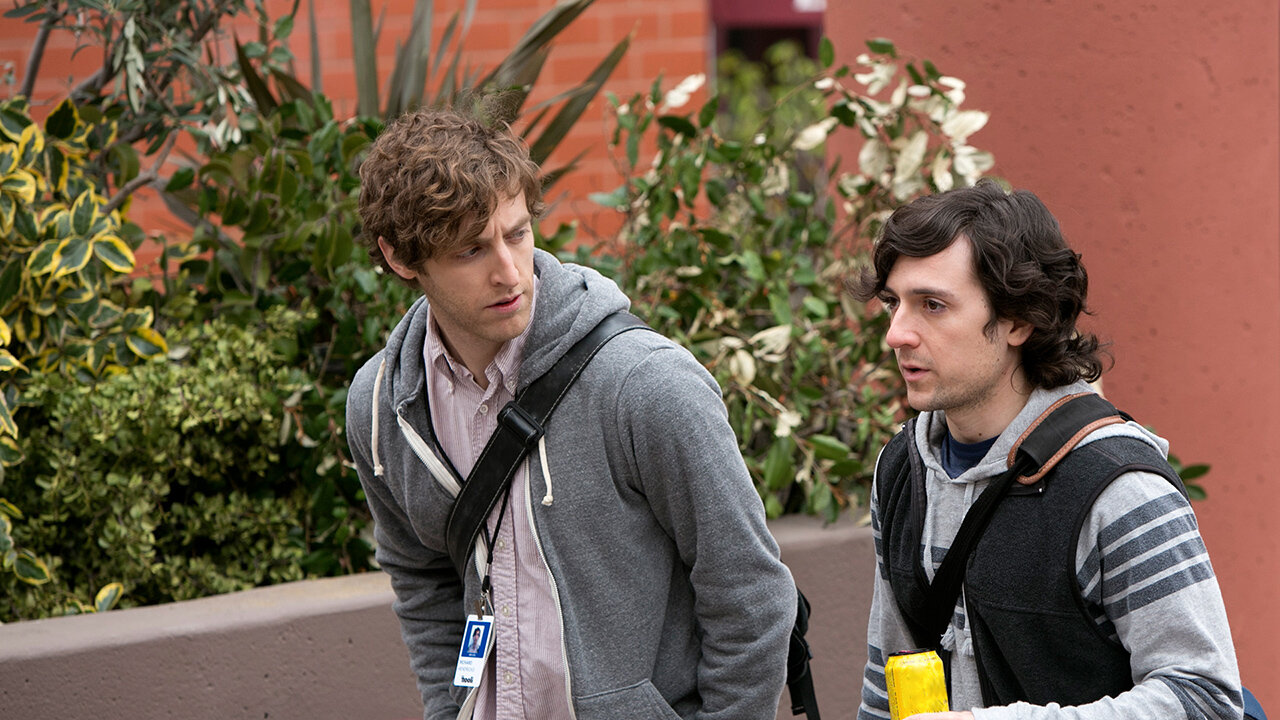

In [60]:
image0 = (shows.select("_embedded.episodes")
  .select(F.col("episodes")[0].alias("element00"))
  .select(F.col("element00.image.medium")))
image0.show(1, False)

# optional
display(Image(image0.collect()[0]["medium"].strip(), width=400))

image0 = (shows.select("_embedded.episodes")
  .select(F.col("episodes")[0].alias("element00"))
  .select(F.col("element00.image.original")))
image0.show(1, False)

# optional
display(Image(image0.collect()[0]["original"].strip(), width=400))

Get a rating for the selected episode

In [61]:
(shows.select("_embedded.episodes")
  .select(F.col("episodes")[0].alias("element00"))
  .select(F.col("element00.rating"))
  .show(1, False))

+------+
|rating|
+------+
|{6.0} |
+------+



**Self-exercise**: Can you get all ratings for all episodes in a single table?   
Hint: use `F.explode()`

Get all tables that have string elements (except `summary`)

In [66]:
(shows.select("_embedded.episodes")
 .select(F.col("episodes")[0].alias("element00"))
 .select(F.col("element00")["airdate"].alias("airdate"),
         F.col("element00")["airstamp"].alias("airstamp"),
         F.col("element00")["airtime"].alias("airtime"),
         F.col("element00")["name"].alias("name"),
         F.col("element00")["type"].alias("type"),
         F.col("element00")["url"].alias("url"))
  .show(1, False)
)

+----------+-------------------------+-------+----------------------+-------+--------------------------------------------------------------------------------+
|airdate   |airstamp                 |airtime|name                  |type   |url                                                                             |
+----------+-------------------------+-------+----------------------+-------+--------------------------------------------------------------------------------+
|2014-04-06|2014-04-07T02:00:00+00:00|22:00  |Minimum Viable Product|regular|https://www.tvmaze.com/episodes/10897/silicon-valley-1x01-minimum-viable-product|
+----------+-------------------------+-------+----------------------+-------+--------------------------------------------------------------------------------+



In [69]:
summary0 = (shows.select("_embedded.episodes")
 .select(F.col("episodes")[0].alias("element00"))
 .select(F.col("element00")["summary"].alias("summary"))
)
summary0.show(1, False)

display(HTML(summary0.collect()[0].summary))

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|summary                                                                                                                                                                                                                                                                                                                                                                                     

Get all the tables that have long (integer) elements

In [70]:
(shows.select("_embedded.episodes")
  .select(F.col("episodes")[0].alias("element00"))
  .select(F.col("element00")["id"].alias("id"),
          F.col("element00")["number"].alias("number"),
          F.col("element00")["runtime"].alias("runtime"),
          F.col("element00")["season"].alias("season"))
  .show(1, False))

+-----+------+-------+------+
|id   |number|runtime|season|
+-----+------+-------+------+
|10897|1     |30     |1     |
+-----+------+-------+------+



Doing a promotion of `episodes` to one level higher and dropping `_embedded`

<img src="./img-resources/06-multidim-data-shows-promote-with-drop.png" width=1000>

In [71]:
# remove _embedded, and put _embedded.episodes as a new column with a name "episodes"
# and it contains an array of episodes of Silicon Valley.
shows_clean = shows.withColumn(
  "episodes", F.col("_embedded.episodes")
).drop("_embedded")

# In the last column, you will see the column `episodes`
shows_clean.show()

+--------------------+--------------+----------+----------+--------------------+--------+---+--------------------+--------+--------------+--------------------+--------------------+----------+------+-------+-----------------+------+--------------------+--------+----------+--------------------+----------+------+--------------------+
|              _links|averageRuntime|dvdCountry|     ended|           externals|  genres| id|               image|language|          name|             network|        officialSite| premiered|rating|runtime|         schedule|status|             summary|    type|   updated|                 url|webChannel|weight|            episodes|
+--------------------+--------------+----------+----------+--------------------+--------+---+--------------------+--------+--------------+--------------------+--------------------+----------+------+-------+-----------------+------+--------------------+--------+----------+--------------------+----------+------+--------------------+
|

In [73]:
shows_clean.printSchema()

root
 |-- _links: struct (nullable = true)
 |    |-- previousepisode: struct (nullable = true)
 |    |    |-- href: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- self: struct (nullable = true)
 |    |    |-- href: string (nullable = true)
 |-- averageRuntime: long (nullable = true)
 |-- dvdCountry: string (nullable = true)
 |-- ended: string (nullable = true)
 |-- externals: struct (nullable = true)
 |    |-- imdb: string (nullable = true)
 |    |-- thetvdb: long (nullable = true)
 |    |-- tvrage: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- medium: string (nullable = true)
 |    |-- original: string (nullable = true)
 |-- language: string (nullable = true)
 |-- name: string (nullable = true)
 |-- network: struct (nullable = true)
 |    |-- country: struct (nullable = true)
 |    |    |-- code: string (nullable

Get the name of all episodes

In [76]:
(shows_clean.select(F.col("episodes.name"))
  .select(F.explode("name").alias("name"))
  .show(100, False))

+---------------------------------+
|name                             |
+---------------------------------+
|Minimum Viable Product           |
|The Cap Table                    |
|Articles of Incorporation        |
|Fiduciary Duties                 |
|Signaling Risk                   |
|Third Party Insourcing           |
|Proof of Concept                 |
|Optimal Tip-to-Tip Efficiency    |
|Sand Hill Shuffle                |
|Runaway Devaluation              |
|Bad Money                        |
|The Lady                         |
|Server Space                     |
|Homicide                         |
|Adult Content                    |
|White Hat/Black Hat              |
|Binding Arbitration              |
|Two Days of the Condor           |
|Founder Friendly                 |
|Two in the Box                   |
|Meinertzhagen's Haversack        |
|Maleant Data Systems Solutions   |
|The Empty Chair                  |
|Bachmanity Insanity              |
|To Build a Better Beta     

## Create your own schema: hard coding

Now we want to provide a schema when reading a data.  
Here is the schema for `_embedded` key in  `shows-silicon-valley.json`

In [ ]:
# schema for field _links
episode_links_schema = T.StructType([
  T.StructField(
    "self", T.StructType([T.StructField("href", T.StringType())])
  ),
  T.StructField(
    "show", T.StructType([
      T.StructField("href", T.StringType()),
      T.StructField("name", T.StringType())
    ])
  )
])

# schema for field image
episode_image_schema = T.StructType([
  T.StructField("medium", T.StringType()),
  T.StructField("original", T.StringType())
])

# schema for field image
episode_rating_schema = T.StructType([
  T.StructField("average", T.DoubleType())
])

# schema for field each element in episodes
episode_schema = T.StructType([
  T.StructField("_links", episode_links_schema),
  T.StructField("image", episode_image_schema),
  T.StructField("rating", episode_rating_schema),
  T.StructField("airdate", T.DateType()),
  T.StructField("airstamp", T.TimestampType()),
  T.StructField("airtime", T.StringType()),
  T.StructField("name", T.StringType()),
  T.StructField("summary", T.StringType()),
  T.StructField("id", T.StringType()),
  T.StructField("number", T.LongType()),
  T.StructField("runtime", T.LongType()),
  T.StructField("season", T.LongType()),
  T.StructField("type", T.StringType()),
  T.StructField("url", T.StringType())
])

# schema for field _embedded
embedded_schema = T.StructType([
  T.StructField(
    "_embedded", 
    T.StructType([
        T.StructField("episodes", T.ArrayType(episode_schema))])
  )
])


## Create your own schema: JSON format

## Reducing data hierarchy complexity: `explode()` and `collect()`

## Build your own struct literally